<a href="https://colab.research.google.com/github/rwagler/Exercise-Digital-Business-and-Platfroms/blob/main/exercise_07_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the KumoRFM Python SDK
KumoRFM provides an SDK in Python. The Kumo SDK is available for Python 3.9 to Python 3.13

In [2]:
!pip install kumoai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.8 MB/s eta 0:00:00


In [3]:
import kumoai.experimental.rfm as rfm

You will need an API key to make calls to KumoRFM.
Use the widget below to generate one for free by clicking "Generate API Key".
If you don't have a KumoRFM account, the widget will prompt you to signup.

You will see the following when your key has been created successfully:

<div align="left">
  <img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/rfm-colabs/api-key-created.png" width="300" />
</div>

In [4]:
import os

from google.colab import userdata
userdata.get('KUMO_API_KEY')

if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

In [6]:
# Initialize a Kumo client with your API key:
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

INFO:kumoai:Successfully initialized the Kumo SDK (version 2.12.1) against deployment https://kumorfm.ai/api, with log level INFO.


## Load the Data

In [7]:
root = 's3://kumo-sdk-public/rfm-datasets/ecom'
path_dict = {
    'users': f'{root}/users.parquet',
    'items': f'{root}/items.parquet',
    'views': f'{root}/views.parquet',
    'orders': f'{root}/orders.parquet',
    'returns': f'{root}/returns.parquet',
}

In [8]:
# load data into pandas dataframes
import pandas as pd

df_users = pd.read_parquet(path_dict['users'])
df_items = pd.read_parquet(path_dict['items'])
df_views = pd.read_parquet(path_dict['views'])
df_orders = pd.read_parquet(path_dict['orders'])
df_returns = pd.read_parquet(path_dict['returns'])

### Familiarize with the data structure

#### User Data

In [9]:
df_users.head(5)

,user_id,fn,active,club_member_status,fashion_news_frequency,age
0,0,True,True,ACTIVE,Regularly,49
1,1,False,False,ACTIVE,None,28
2,2,True,True,ACTIVE,Regularly,26
3,3,True,True,ACTIVE,Regularly,20
4,4,True,True,ACTIVE,Regularly,40


In [10]:
df_users.dtypes

,0
user_id,int64
fn,bool
active,bool
club_member_status,object
fashion_news_frequency,object
age,Int64


In [12]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11463 entries, 0 to 11462
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 11463 non-null  int64 
 1   fn                      11463 non-null  bool  
 2   active                  11463 non-null  bool  
 3   club_member_status      11417 non-null  object
 4   fashion_news_frequency  11463 non-null  object
 5   age                     11326 non-null  Int64 
dtypes: Int64(1), bool(2), int64(1), object(2)
memory usage: 391.9+ KB


#### Items

In [44]:
df_items.head(5)

,item_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,color_group_name,perceived_color_value_name,perceived_color_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,0,VIOLET JEANS,Trousers,Garment Lower body,Denim,Blue,Medium Dusty,Blue,Denim Other Garments,Divided,Divided,Ladies Denim,Trousers Denim,"5-pocket, high-waisted, ankle-length jeans in ..."
1,1,Tulip Top,Blouse,Garment Upper body,Lace,Dark Red,Dark,Red,Woven Occasion,Ladieswear,Ladieswear,Womens Premium,Dresses Ladies,"Sleeveless, fitted lace top with a small, scal..."
2,2,Nova,Cardigan,Garment Upper body,Solid,Black,Dark,Black,Kids Girl Knitwear,Children Sizes 92-140,Baby/Children,Kids Girl,Knitwear,Cardigan in fine-knit cotton with a round neck...
3,3,Bjorne lined cargo,Trousers,Garment Lower body,Solid,Dark Beige,Medium Dusty,Brown,Kids Boy Trouser,Children Sizes 92-140,Baby/Children,Kids Boy,Trousers,Cargo trousers in a cotton weave with an elast...
4,4,Hawlin Headband,Hat/beanie,Accessories,Melange,Dark Grey,Dark,Grey,Gloves/Hats,Ladies Accessories,Ladieswear,Womens Big accessories,Accessories,Headband in a soft knit containing some wool w...


In [43]:
df_items.dtypes

,0
item_id,int64
prod_name,object
product_type_name,object
product_group_name,object
graphical_appearance_name,object
color_group_name,object
perceived_color_value_name,object
perceived_color_master_name,object
department_name,object
index_name,object


In [13]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46971 entries, 0 to 46970
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   item_id                      46971 non-null  int64 
 1   prod_name                    46971 non-null  object
 2   product_type_name            46971 non-null  object
 3   product_group_name           46971 non-null  object
 4   graphical_appearance_name    46971 non-null  object
 5   color_group_name             46971 non-null  object
 6   perceived_color_value_name   46971 non-null  object
 7   perceived_color_master_name  46971 non-null  object
 8   department_name              46971 non-null  object
 9   index_name                   46971 non-null  object
 10  index_group_name             46971 non-null  object
 11  section_name                 46971 non-null  object
 12  garment_group_name           46971 non-null  object
 13  detail_desc                  46

#### Orders

In [42]:
df_orders.head(5)

,user_id,item_id,date,sales_channel_id,price,order_id
0,1102,10087,2018-09-20,2,7.31,0
1,4994,13442,2018-09-20,2,13.99,1
2,4994,7872,2018-09-20,2,42.38,2
3,2185,5856,2018-09-20,1,25.68,3
4,7267,1855,2018-09-20,1,34.03,4


In [41]:
df_orders.dtypes

,0
user_id,int64
item_id,int64
date,datetime64[us]
sales_channel_id,int64
price,float64
order_id,int64


In [40]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267774 entries, 0 to 267773
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           267774 non-null  int64         
 1   item_id           267774 non-null  int64         
 2   date              267774 non-null  datetime64[us]
 3   sales_channel_id  267774 non-null  int64         
 4   price             267774 non-null  float64       
 5   order_id          267774 non-null  int64         
dtypes: datetime64[us](1), float64(1), int64(4)
memory usage: 12.3 MB


#### Returns

In [39]:
df_returns.head(5)

,user_id,item_id,date,reason,return_id,order_id
0,354,7380,2018-09-20,quality not as expected,0,311
1,7361,7597,2018-09-20,changed my mind,1,37
2,838,13151,2018-09-21,quality not as expected,2,349
3,5314,10270,2018-09-21,changed my mind,3,745
4,7460,6638,2018-09-21,color not as expected,4,92


In [38]:
df_returns.dtypes

,0
user_id,int64
item_id,int64
date,datetime64[us]
reason,object
return_id,int64
order_id,int64


In [15]:
df_returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72327 entries, 0 to 72326
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    72327 non-null  int64         
 1   item_id    72327 non-null  int64         
 2   date       72327 non-null  datetime64[us]
 3   reason     72327 non-null  object        
 4   return_id  72327 non-null  int64         
 5   order_id   72327 non-null  int64         
dtypes: datetime64[us](1), int64(4), object(1)
memory usage: 3.3+ MB


#### Views

In [37]:
df_views.head(5)

,user_id,item_id,date,view_id
0,7460,9006,2018-08-21,0
1,6043,3428,2018-08-21,1
2,6818,12163,2018-08-21,2
3,4994,11308,2018-08-21,3
4,5676,1766,2018-08-21,4


In [36]:
df_views.dtypes

,0
user_id,int64
item_id,int64
date,datetime64[us]
view_id,int64


In [35]:
df_views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964987 entries, 0 to 964986
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  964987 non-null  int64         
 1   item_id  964987 non-null  int64         
 2   date     964987 non-null  datetime64[us]
 3   view_id  964987 non-null  int64         
dtypes: datetime64[us](1), int64(3)
memory usage: 29.4 MB


## Turn the data into KumoRFM tables

In [45]:
users = rfm.LocalTable(df_users, name="users").infer_metadata()
orders = rfm.LocalTable(df_orders, name="orders").infer_metadata()
items = rfm.LocalTable(df_items, name="items").infer_metadata()
returns = rfm.LocalTable(df_returns, name="returns").infer_metadata()
views = rfm.LocalTable(df_views, name="views").infer_metadata()

Detected primary key 'user_id' in table 'users'
Detected primary key 'order_id' and time column 'date' in table 'orders'
Detected primary key 'item_id' in table 'items'
Detected primary key 'return_id' and time column 'date' in table 'returns'
Detected primary key 'view_id' and time column 'date' in table 'views'


### Inspecting metadata

#### Users

In [46]:
users.print_metadata()

### 🏷️ Metadata of Table `users` (11,463 rows)

name,dtype,stype,is_primary_key,is_time_column,is_end_time_column
user_id,int,ID,True,False,False
fn,bool,categorical,False,False,False
active,bool,categorical,False,False,False
club_member_status,string,categorical,False,False,False
fashion_news_frequency,string,categorical,False,False,False
age,int,numerical,False,False,False


#### Orders

In [47]:
orders.print_metadata()

### 🏷️ Metadata of Table `orders` (267,774 rows)

name,dtype,stype,is_primary_key,is_time_column,is_end_time_column
user_id,int,ID,False,False,False
item_id,int,ID,False,False,False
date,date,timestamp,False,True,False
sales_channel_id,int,ID,False,False,False
price,float,numerical,False,False,False
order_id,int,ID,True,False,False


#### Items

In [48]:
items.print_metadata()

### 🏷️ Metadata of Table `items` (46,971 rows)

name,dtype,stype,is_primary_key,is_time_column,is_end_time_column
item_id,int,ID,True,False,False
prod_name,string,text,False,False,False
product_type_name,string,categorical,False,False,False
product_group_name,string,categorical,False,False,False
graphical_appearance_name,string,categorical,False,False,False
color_group_name,string,categorical,False,False,False
perceived_color_value_name,string,categorical,False,False,False
perceived_color_master_name,string,categorical,False,False,False
department_name,string,categorical,False,False,False
index_name,string,categorical,False,False,False


#### Returns

In [49]:
returns.print_metadata()

### 🏷️ Metadata of Table `returns` (72,327 rows)

name,dtype,stype,is_primary_key,is_time_column,is_end_time_column
user_id,int,ID,False,False,False
item_id,int,ID,False,False,False
date,date,timestamp,False,True,False
reason,string,categorical,False,False,False
return_id,int,ID,True,False,False
order_id,int,ID,False,False,False


#### Views

In [50]:
views.print_metadata()

### 🏷️ Metadata of Table `views` (964,987 rows)

name,dtype,stype,is_primary_key,is_time_column,is_end_time_column
user_id,int,ID,False,False,False
item_id,int,ID,False,False,False
date,date,timestamp,False,True,False
view_id,int,ID,True,False,False


## Create a Graph based on the Data

In [51]:
graph = rfm.LocalGraph.from_data({
    'users': df_users,
    'orders': df_orders,
    'items': df_items,
    'returns': df_returns,
    'views': df_views,
}, infer_metadata=True)

### 🗂️ Graph Metadata

name,primary_key,time_column,end_time_column
users,user_id,-,-
orders,order_id,date,-
items,item_id,-,-
returns,return_id,date,-
views,view_id,date,-


### 🕸️ Graph Links (FK ↔️ PK)

- `orders.item_id` ↔️ `items.item_id`
- `returns.item_id` ↔️ `items.item_id`
- `views.item_id` ↔️ `items.item_id`
- `returns.order_id` ↔️ `orders.order_id`
- `orders.user_id` ↔️ `users.user_id`
- `returns.user_id` ↔️ `users.user_id`
- `views.user_id` ↔️ `users.user_id`

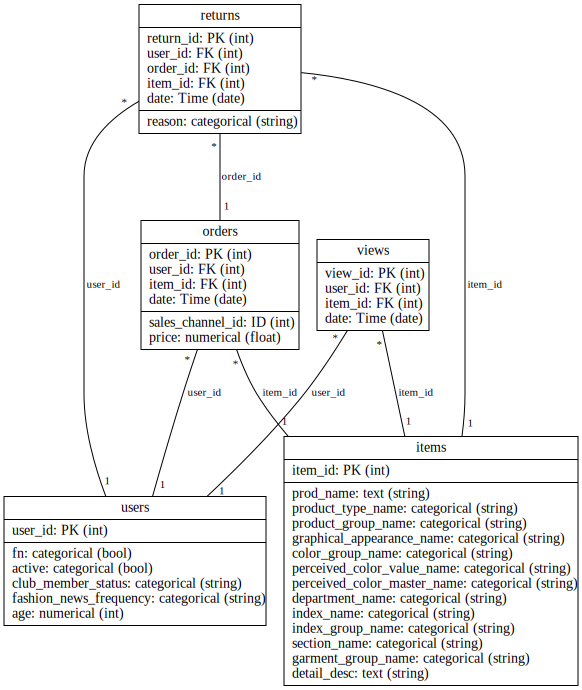

In [52]:
graph.visualize();

## Materialize Graph

In [53]:
model = rfm.KumoRFM(graph)

Output()

## Query the graph

In [54]:
def query_graph(query, indices=None):
    df = model.predict(query, indices=indices)
    display(df)
    return df

### Identify Users for churn risk prediction
- KumoRFM can predict a value for a maximum of 1000 entities, so we need to do a preliminary filitering
- Therefore, we just look at the 100 most recent returns.

In [55]:
df = df_returns.sort_values('date', ascending=False)
target_users = df['user_id'].drop_duplicates().head(100).to_list()
print(len(target_users))

100


### Perform Prediction
Predict the churn probability for the selected customers in the next 30 days.

In [56]:
query = "PREDICT COUNT(orders.*, 0, 30, days) > 0 FOR EACH users.user_id"

In [57]:
churn_riks = query_graph(query=query, indices=target_users)

Output()

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,11099,2020-09-19,False,0.743152,0.256848
1,11460,2020-09-19,False,0.810856,0.189144
2,5803,2020-09-19,True,0.353250,0.646750
3,4012,2020-09-19,False,0.550025,0.449975
4,2873,2020-09-19,False,0.586373,0.413627
...,...,...,...,...,...
95,4862,2020-09-19,False,0.753058,0.246942
96,8523,2020-09-19,False,0.870575,0.129425
97,106,2020-09-19,True,0.484955,0.515045
98,11008,2020-09-19,False,0.696566,0.303434


The probabilities indicate the likelihood of each user's future order activity, where a higher false probability suggests a higher risk of churn.

In [58]:
churn_riks_sorted = churn_riks.sort_values(by='False_PROB', ascending=False)
display(churn_riks_sorted)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
82,9095,2020-09-19,False,0.965821,0.034179
39,10492,2020-09-19,False,0.952804,0.047196
66,9233,2020-09-19,False,0.909242,0.090758
25,4593,2020-09-19,False,0.904192,0.095808
38,7088,2020-09-19,False,0.879223,0.120778
...,...,...,...,...,...
12,7239,2020-09-19,True,0.209971,0.790029
31,5909,2020-09-19,True,0.186736,0.813264
8,1737,2020-09-19,True,0.184640,0.815360
62,7618,2020-09-19,True,0.183031,0.816969


## Generate a Product Recommendation for the top-5 customers that are likely to churn

Generate 3 Product Recommendations for each customer.


In [62]:
df_top5 = churn_riks_sorted.head(5)
display(df_top5)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
82,9095,2020-09-19,False,0.965821,0.034179
39,10492,2020-09-19,False,0.952804,0.047196
66,9233,2020-09-19,False,0.909242,0.090758
25,4593,2020-09-19,False,0.904192,0.095808
38,7088,2020-09-19,False,0.879223,0.120778


In [64]:
top5= df_top5['ENTITY'].to_list()

In [67]:
query = "PREDICT LIST_DISTINCT(orders.item_id, 0, 30, days) RANK TOP 3 FOR EACH users.user_id"

In [68]:
recommendation = query_graph(query=query, indices=top5)

Output()

,ENTITY,ANCHOR_TIMESTAMP,CLASS,SCORE
0,9095,2020-09-19,21061,0.950319
1,9095,2020-09-19,33783,0.877896
2,9095,2020-09-19,46804,0.596433
3,10492,2020-09-19,43161,0.605333
4,10492,2020-09-19,38349,0.577019
5,10492,2020-09-19,27753,0.373876
6,9233,2020-09-19,44173,0.979315
7,9233,2020-09-19,21240,0.871912
8,9233,2020-09-19,16393,0.861538
9,4593,2020-09-19,35842,0.936634


In [69]:
recommendation_with_item_details = recommendation.rename(columns={'CLASS': 'item_id'})
recommendation_with_item_details = pd.merge(recommendation_with_item_details, df_items[['item_id', 'prod_name']], on='item_id', how='left')

display(recommendation_with_item_details[['ENTITY', 'item_id', 'SCORE', 'prod_name']])

,ENTITY,item_id,SCORE,prod_name
0,9095,21061,0.950319,Bloom (1)
1,9095,33783,0.877896,POW Johanna dress
2,9095,46804,0.596433,ESSENTIAL TANKTOP LACE TVP
3,10492,43161,0.605333,PQ DOTTIE SILK SHIRT PRINT
4,10492,38349,0.577019,ESSENTIAL TANKTOP LACE
5,10492,27753,0.373876,DUSTY French placket- linen
6,9233,44173,0.979315,Orlando Wireless Abeline
7,9233,21240,0.871912,Gerda dress
8,9233,16393,0.861538,Thunder dress
9,4593,35842,0.936634,Malin Leggings
